In [8]:
import dill
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from pyfftw.interfaces.numpy_fft import fftshift, ifftshift, fft2, ifft2
from SimulationObjects import PtychographySimulation
from PIL import Image

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.seterr(all='raise')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [129]:
def lossFunction(tf_diff_int, tf_probe, tf_obj,
                 indices, n_x_points, n_y_points, nr, nc, shiftx_pix, shifty_pix,
                 lambda_tv_exit_wv=0):
    np.random.shuffle(indices)
    losses = []
    penalties = []
    for j in indices:
        r = j // n_y_points
        c = j % n_x_points
        diff = tf_diff_int[r,c]
        nr1 = r * shifty_pix
        nr2 = nr1 + nr
        nc1 = c * shiftx_pix
        nc2 = nc1 + nc
        exit_wave_guess = tf_probe * tf_obj[nr1:nr2, nc1:nc2]
        f1 = tf.fft2d(exit_wave_guess)

        loss = tf.reduce_mean(tf.abs(tf.abs(f1) - tf.sqrt(diff)))
        losses.append(loss)


    return tf.reduce_mean(losses)
            
def optimize(diffraction_intensities, obj_init, probe_init,
             shiftx_pix, shifty_pix,
             n_steps=5000, probe_fixed_iterations=None,
             learning_rate_obj=1e-3, learning_rate_probe=1e-3,
             verbose=False):
    
    probe_fixed_iterations = probe_fixed_iterations if probe_fixed_iterations is not None else n_steps
    
    n_y_points, n_x_points, n1, n2 = diffraction_intensities.shape
    nr = n1
    nc = n2
    indices = np.arange(0, n_y_points * n_x_points)
    diffraction_intensities_shifted = np.zeros_like(diffraction_intensities)
    
    for i in range(n_y_points):
        for j in range(n_x_points):
            diffraction_intensities_shifted[i,j] = fftshift(diffraction_intensities[i,j])
    
    errors = []
    with tf.Graph().as_default():
        tf_diff_int = tf.constant(diffraction_intensities_shifted, dtype=tf.float32, name='diffraction_intensities')
        
        tf_probe_real = tf.Variable(np.real(probe_init), dtype=tf.float32)
        tf_probe_imag = tf.Variable(np.imag(probe_init), dtype=tf.float32)
        
        tf_obj_real = tf.Variable(np.real(obj_init), dtype=tf.float32)
        tf_obj_imag = tf.Variable(np.imag(obj_init), dtype=tf.float32)
        
        tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
        tf_probe = tf.complex(tf_probe_real, tf_probe_imag)
        
        loss = lossFunction(tf_diff_int, tf_probe, tf_obj, indices, n_x_points,  n_y_points, nr, nc, shiftx_pix, shifty_pix) 
        

        optimizer_probe = tf.train.AdamOptimizer(learning_rate_probe)
        optimizer_obj = tf.train.AdamOptimizer(learning_rate_obj)

        op_obj = optimizer_obj.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])
        op_probe = optimizer_probe.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
        
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)

        
        
        for count in tqdm(range(n_steps)):
            
            sess.run(op_obj)
            
            if count >= probe_fixed_iterations: 
                sess.run(op_probe)
            
            if count % 100 == 0: 
                objval, lossval = sess.run([tf_obj, loss])
                testobj = objval[32:96,32:96]
                testobj = np.abs(testobj) * np.exp(1j * (np.angle(testobj) - np.mean(np.angle(testobj))))
                error = np.mean(np.abs(testobj - testimg))
                errors.append(error)
        
        final_obj, final_probe = sess.run([tf_obj, tf_probe])
        return final_obj, final_probe, errors

In [117]:
def getTestImage(mod='mod2.png', phase='phase2.png'):
    modulus = np.asarray(Image.open(mod).convert('L'), dtype='float')[::-1]
    phase = np.asarray(Image.open(phase).convert('L'), dtype='float')[::-1]
    modulus = modulus / modulus.max()
    phase = phase / phase.max() * np.pi - np.pi / 2
    image = modulus * np.exp(1j * phase)
    return image

In [118]:
def diffract(img):
    sim_obj = PtychographySimulation(img,
                                     probe_width_dist=1.5e-5, 
                                     probe_propagation_dist=0,
                                     probe_type='square',
                                     probe_step_dist=9e-6,
                                     det_pix_num = 64,
                                     probe_n_photons = 1e9,
                                     det_zdist = 14,
                                     noise=False)
    sim_obj.calculateDiffraction()
    return sim_obj

In [119]:
actual_img = getTestImage(mod='mod2.png', phase='phase2.png')
testimg = actual_img[32:96, 32:96]
sim_obj = diffract(actual_img)
sim_obj.obj.vals.shape

(128, 128)

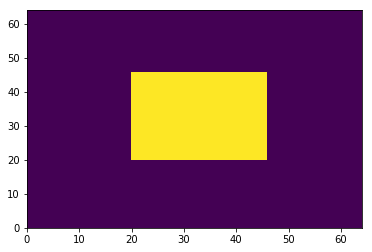

In [121]:
plt.pcolormesh(np.abs(sim_obj.probe.vals))
plt.show()

In [124]:
obj_init = np.ones_like(sim_obj.obj.vals)
probe_init = sim_obj.probe.vals
final_obj, final_probe, errors = optimize(sim_obj.diffraction_intensities, obj_init, probe_init, 
                                          sim_obj.step_pix, sim_obj.step_pix,
                                          n_steps=5000, learning_rate_obj=5e-4)

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

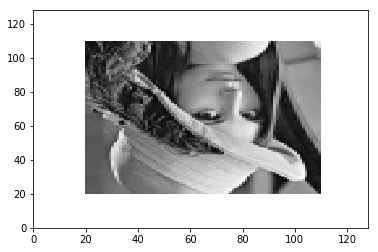

In [128]:
plt.pcolormesh(np.abs(final_obj), cmap='gray')
plt.show()